In [1]:
!pip install pytorch-crf

In [2]:
import torch
import torch.nn as nn
import numpy as np
from transformers import AutoModel, AutoTokenizer, AdamW
from datasets import load_dataset
from torchcrf import CRF
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
seed = 10

cuda


In [3]:
train_size = 18000
val_size = 5000

model_identifier = "SpanBERT/spanbert-base-cased"
dataset = load_dataset("squad_v2")
train_data = dataset["train"].shuffle(seed = seed).select(range(train_size))
val_data = dataset["validation"].shuffle(seed = seed).select(range(val_size))
tokenizer = AutoTokenizer.from_pretrained(model_identifier)

README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [4]:
def preprocess(data):
    encoding = tokenizer(
        data['context'],
        data['question'],
        truncation = True,
        padding = True,
        max_length = 512,
        return_tensors = 'pt'
    )

    start_idx = data['answers']['answer_start'][0] if data['answers']['text'] else -1
    end_idx = start_idx + len(data['answers']['text'][0]) if data['answers']['text'] else -1

    targets = torch.zeros(encoding['input_ids'].shape, dtype = torch.long)
    if start_idx != -1 and end_idx != -1:
        targets[0, start_idx:end_idx] = 1

    return {
        'input_ids' : encoding['input_ids'].squeeze(0),
        'attention_mask' : encoding['attention_mask'].squeeze(0),
        'targets' : targets.squeeze(0)
    }

def collate_fn(batch):
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    attention_mask = [torch.tensor(item['attention_mask']) for item in batch]
    targets = [torch.tensor(item['targets']) for item in batch]
    
    max_len = max(x.shape[0] for x in input_ids)
    
    input_ids = torch.stack([torch.cat([x, torch.zeros(max_len - x.shape[0], dtype=torch.long)]) for x in input_ids])
    attention_mask = torch.stack([torch.cat([x, torch.zeros(max_len - x.shape[0], dtype=torch.long)]) for x in attention_mask])
    targets = torch.stack([torch.cat([x, torch.full((max_len - x.shape[0],), -1, dtype=torch.long)]) for x in targets])
    
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'targets': targets}


train_data = train_data.map(preprocess, remove_columns = train_data.column_names)
val_data = val_data.map(preprocess, remove_columns = val_data.column_names)

train_dataloader = DataLoader(train_data, batch_size = 8, shuffle = True, collate_fn = collate_fn)
val_dataloader = DataLoader(val_data, batch_size = 8, shuffle = False, collate_fn = collate_fn)

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [5]:
class SpanBERT_CRF(nn.Module):
    def __init__(self, model_identifier, num_classes):
        super(SpanBERT_CRF, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_identifier)
        self.feature_dim = self.encoder.config.hidden_size
        self.output_layer = nn.Linear(self.feature_dim, num_classes)
        self.crf_layer = CRF(num_classes, batch_first=True)

    def forward(self, input_ids, attention_mask, targets=None):
        encoded_output = self.encoder(input_ids, attention_mask=attention_mask)
        hidden_states = encoded_output.last_hidden_state
        emissions = self.output_layer(hidden_states)

        if targets is not None:
            loss_value = -self.crf_layer(emissions, targets, mask=attention_mask.bool(), reduction='mean')
            return {"loss": loss_value, "logits": emissions}
        
        return {"logits": emissions}

def train_model(model, train_dataloader, val_dataloader, device, optimizer, epochs=6):
    model.to(device)
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, targets)
            loss = outputs['loss']
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            progress_bar.set_postfix(loss=total_train_loss / len(train_dataloader))
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        avg_val_loss = evaluate_model(model, val_dataloader, device, compute_metrics=False)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    
    return train_losses, val_losses

def evaluate_model(model, val_dataloader, device, compute_metrics=True, tokenizer = None):
    model.eval()
    total_loss = 0
    all_predictions, all_labels = [] ,[]
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)
            
            outputs = model(input_ids, attention_mask, targets)
            loss = outputs['loss']
            total_loss += loss.item()
            predictions = outputs['logits'].cpu().numpy()
            all_predictions.extend(predictions)
            all_labels.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(val_dataloader)
    if compute_metrics:
        eval_results = evaluate_metrics(all_predictions, tokenizer, val_dataloader.dataset)
        print(f"Final Validation Metrics: {eval_results}")
    
    return avg_loss

def exact_match_score(predictions, references):
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p.strip() == r.strip() for p, r in zip(predictions, references))
    return matches / len(references) * 100

def evaluate_metrics(predictions, tokenizer, test_data):
    predicted_labels = [
        (np.argmax(point[:, 0]), np.argmax(point[:, 1]))
        for point in predictions
    ]
    
    true_labels = []
    for sequence in test_data:
        start_idx, end_idx = 0, 0
        
        for idx, label in enumerate(sequence['targets']):
            if label == 1:
                start_idx = idx
                break
        
        for idx in range(len(sequence['targets'])):
            if sequence['targets'][idx] == 1:
                end_idx = idx
        
        true_labels.append((start_idx, end_idx))
    
    decoded_preds = [
        tokenizer.convert_tokens_to_string(
            tokenizer.convert_ids_to_tokens(
                test_data[i]['input_ids'][pred_start:pred_end]
            )
        ).strip()
        for i, (pred_start, pred_end) in enumerate(predicted_labels)
    ]
    
    decoded_labels = [
        tokenizer.convert_tokens_to_string(
            tokenizer.convert_ids_to_tokens(
                test_data[i]['input_ids'][label_start:label_end]
            )
        ).strip()
        for i, (label_start, label_end) in enumerate(true_labels)
    ]
    
    exact_match = exact_match_score(decoded_preds, decoded_labels)
    return {'exact_match': exact_match}


In [6]:
model = SpanBERT_CRF(model_identifier, 2)
optimizer = AdamW(model.parameters(), lr = 5e-5)

train_losses, val_losses = train_model(model, train_dataloader, val_dataloader, device, optimizer)

pytorch_model.bin:   0%|          | 0.00/215M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 2250/2250 [27:30<00:00,  1.36it/s, loss=18.4]


Epoch 1 - Training Loss: 18.3582 | Validation Loss: 14.1792


Epoch 2: 100%|██████████| 2250/2250 [27:53<00:00,  1.34it/s, loss=16.9]


Epoch 2 - Training Loss: 16.9403 | Validation Loss: 13.1142


Epoch 3: 100%|██████████| 2250/2250 [27:47<00:00,  1.35it/s, loss=15.6]


Epoch 3 - Training Loss: 15.6062 | Validation Loss: 12.1004


Epoch 4: 100%|██████████| 2250/2250 [27:54<00:00,  1.34it/s, loss=14.3]


Epoch 4 - Training Loss: 14.3137 | Validation Loss: 11.1790


Epoch 5: 100%|██████████| 2250/2250 [27:45<00:00,  1.35it/s, loss=13.1]


Epoch 5 - Training Loss: 13.0687 | Validation Loss: 10.1493


Epoch 6: 100%|██████████| 2250/2250 [27:51<00:00,  1.35it/s, loss=11.9]


Epoch 6 - Training Loss: 11.8734 | Validation Loss: 9.2847


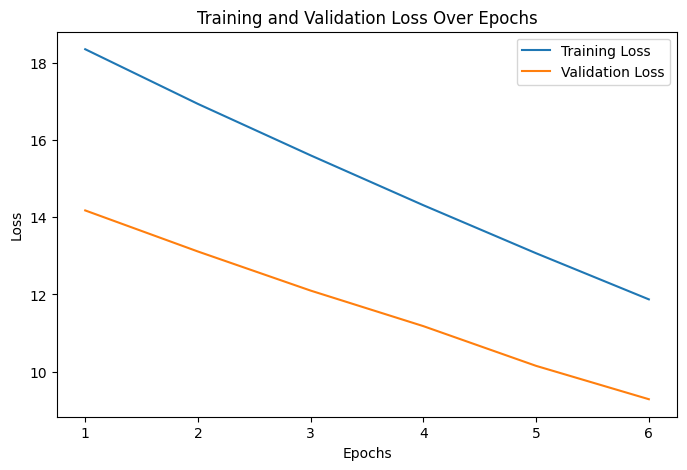

In [7]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Over Epochs")
plt.show()

In [8]:
evaluate_model(model, val_dataloader, device, compute_metrics=True, tokenizer = tokenizer)

torch.save(model.state_dict(), "spanbert_crf_model.pth")
print("Model Saved Successfully !")

Final Validation Metrics: {'exact_match': 52.66}
Model Saved Successfully !
